Given link flows and capacity constraints, this function finds a feasible set of link flows. The inputs to the function are:

f(vector): given (possibly infeasible) link flows

u(vector): link capacity constraints to be met

delta(matrix): link*route incidence matrix

od2route(matrix): K*max_r gives indices of all routes for a given od pair

The output of the function is 

f_feas(vector): feasible link flows for given capacity constraints

In [1]:
debug = False
def find_feasible(f,u,delta,od2route):
    import numpy as np
    delta = np.matrix(delta)
    u = np.array(u)
    
    l = np.shape(f)[0] #number of links in network
    K = np.shape(od2route)[0] #number of od pairs in network
    r = np.shape(delta)[1] #number of routes in network
    d = np.zeros((l,r))
    f_feas = f #vector of feasible flows satisfying capacity constraints
    for k in range(K):
        if debug:
            print('OD pair: %d'%(k+1))
        r_k = od2route[k,:] #vector of indices of all routes bw od pair k
        if isinstance(r_k,list): 
            r_k = r_k[0]
        r_k = r_k[np.invert(np.isnan(r_k))] #take only existing routes
        r_k = r_k.astype(int)
        if debug:
            print('Routes %s'%r_k)
        flag1 = [f_feas>u] 
        sat_f = np.nonzero(flag1)[1] #indices of saturated flows
        d = (delta>0) #binary link route incidence matrix
        d = d*1
        #update the incidence matrix to find saturated flows
    
        # for R in r_k:
        for i in sat_f:
            d[i,:] = 2 * d[i,:]
        #        if d[i,R]>0:
        #            d[i,R] = d[i,R]+1 #matrix indicating routes with saturated links
                    #0: link not in route, 1: unsaturated link, 2: saturated link
        sat = np.where(np.max(d[:,r_k],axis=0)==2)[1] #saturated routes
        unsat = np.where(np.max(d[:,r_k],axis=0)==1)[1] #unsaturated routes
        if np.size(sat)==0 and debug:#if no saturated route is present for a given od pair
            print('No saturated route for OD pair: %d'%(k+1))
        
        else:#presence of at least one saturated route
            f_r = 1.0
            for r in sat:#For each saturated route
                if (np.max(d[:,r],axis=0)==2)&(f_r>0):
                    l_r = np.where(d[:,r]>0)[0] #links in saturated route r
                    f_r = max(f_feas[l_r]-u[l_r]) #flow to be rerouted from saturated route r
                    flag = 1
                    while flag: # as long as the route r remains saturated
                        unsat = np.where(np.max(d[:,r_k],axis=0)==1)[1] #unsaturated routes
                        cap = np.zeros(np.size(unsat))
                        c = 0
                        for us in unsat: #compute extra capacity for unsaturated routes
                            l_u = np.where(d[:,us]>0)[0] #links in unsaturated route u
                            cap[c] = min(u[l_u]-f_feas[l_u]) #extra capacity of unsaturated route u
                            c = c+1
                        i_unsat_sort = np.flip(np.argsort(cap),0) #unsaturated routes sorted in decreasing order of capacities
                        cap_sort = cap[i_unsat_sort] 
                        if f_r<=cap_sort[0]: #all flow to be rerouted can be put in one unsat route
                            f_feas[np.where(d[:,r]>0)[0]] = f_feas[np.where(d[:,r]>0)[0]]-f_r #remove f_r from sat route r
                            f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]] = f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]]+f_r #move f_r to route with highest capacity
                            gl = np.where(d[:,r]==2)[0]
                            d[np.where(d[:,r]>0)[0],r] = 1
                            d[gl,np.where(d[gl,:]>0)[1]] = 1
                            flag = 0
                        else: #split flow to be rerouted
                            f_feas[np.where(d[:,r]>0)[0]] = f_feas[np.where(d[:,r]>0)[0]]-cap_sort[0] #remove cap_sort[0] from sat route r
                            f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]] = f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]]+cap_sort[0] #move f_r to route with highest capacity
                            f_r = f_r-cap_sort[0]
                            flag = 1
    if debug:
        print('Capacities:')
        print(u)
        print('Feasible flows:')
        print(f_feas)
    return f_feas

In [2]:
import numpy as np
f = np.matrix([3.5,1,2.5,1,3.5])
f = f.reshape((5,1))
u = np.matrix([10.0,10.0,2.0,10.0,10.0])
u = u.reshape((5,1))
delta = np.matrix([[1,1,0],[0,0,1],[0,1,0],[1,0,0],[0,1,1]])
od2route = np.array([[0,1,2]])

In [3]:
f_feas = find_feasible(f,u,delta,od2route)

In [4]:
import numpy as np
f = np.matrix([4.0,2.0,3.0,1.0,5.0])
f = f.reshape((5,1))
u = np.matrix([10.0,10.0,2.0,10.0,10.0])
u = u.reshape((5,1))
delta = np.matrix([[1,1,0,1,0],[0,0,1,0,1],[0,1,0,1,0],[1,0,0,0,0],[0,1,1,0,0]])
od2route = np.array([[0,1,2],[3,4,np.nan]])
f_feas = find_feasible(f,u,delta,od2route)

In [5]:
def inv_route_to_od(route2od):
    nb_od = np.max(route2od) + 1
    od2route = {}
    nb_path_max_od_tmp = np.zeros(nb_od, dtype=int)
    for i in range(len(route2od)):
        if route2od[i] not in od2route.keys():
            od2route[route2od[i]] = set()
        od2route[route2od[i]].add(i)
        nb_path_max_od_tmp[route2od[i]] += 1

    nb_path_max_od = np.max(nb_path_max_od_tmp)
    od2route_tmp = np.ones((nb_od, nb_path_max_od)) * np.nan
    for i in od2route.keys():
        for j in range(len(od2route[i])):
            od2route_tmp[i][j] = od2route[i].pop()
    return od2route_tmp

In [6]:
import Frank_Wolf_solver
import lower_bound
import numpy as np
I210 = 'data/I210'
Chic = 'data/Chicago'
Anah = 'data/Anaheim'
Siou = 'data/SiouxFalls'
Brae = 'data/braess'

network_name = Brae
graph, demand = Frank_Wolf_solver.load_network(network_name)

eps=1e-8
nb_iter = 1000
export = False

nb_point = 12
obj_feas = np.zeros(nb_point)
obj_sol = np.zeros(nb_point)
cap_array = np.zeros(nb_point)
var_dual = np.zeros(nb_point)

u_old = [11,11,11,11,11]
if network_name == Brae:
    demand[0][2] = 10
path_flow_matrix_old, tt_f_old, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u_old)
delta = delta.T
f_old = delta @ path_flow_matrix_old
od2route = inv_route_to_od(route2od)
    
if export:
    file = open("results_braess.txt", "w")
for cap_tmp in range(nb_point):
    cap = (12 - (cap_tmp))/2
    c = -1
    if network_name == Brae:
        demand[0][2] = 10
        u = [11, 11, cap, 11, 11]

    f_feas = find_feasible(f_old, u, delta, od2route)
    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u)
    delta = delta.T
    f_sol = delta @ path_flow_matrix
    
    if debug:
        print("++++ TEST ++++")
        print(f_old)
        print(u)
        print((f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1))
    var_dual[cap_tmp], dual_vars, _ = lower_bound.lower_bound(f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1)
    obj_feas[cap_tmp] = Frank_Wolf_solver.potential(graph, f_feas)
    obj_sol[cap_tmp] = Frank_Wolf_solver.potential(graph, f_sol)
    cap_array[cap_tmp] = cap
    
    if export:
        file.write(str(cap) + ", flow sol, " + str(f_sol) + "\n")
        file.write(str(cap) + ", flow upperbound, " + str(f_feas) + "\n")
    
    #f_old = f_sol
    #path_flow_matrix_old = path_flow_matrix
    #tt_f_old = tt_f
    #u_old = u
    print()
    print(cap)
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Objective dual: " + str(var_dual[cap_tmp]))
    
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))
    
if debug:
    print()
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))
if export:
    file.close()
    


6.0
Comparing the solutions:
Objective solution: 31.875000000000213
Objective estimate: 31.875000000000142
Objective dual: 3.625296244320622e-06
Link flow solution: [7.50000147 2.49999853 5.00000005 2.50000142 7.49999858]
Link flow feasible flow: [7.49999837 2.50000163 4.99999904 2.49999933 7.50000067]
Path flow solution: [5.00000005 2.50000142 2.49999853]
Path flow feasible flow: [4.99999904 2.49999933 2.50000163]

5.5
Comparing the solutions:
Objective solution: 31.875000000000824
Objective estimate: 31.875000000000142
Objective dual: 3.6742051948168755e-06
Link flow solution: [7.50000401 2.49999599 5.00000343 2.50000058 7.49999942]
Link flow feasible flow: [7.49999837 2.50000163 4.99999904 2.49999933 7.50000067]
Path flow solution: [5.00000343 2.50000058 2.49999599]
Path flow feasible flow: [4.99999904 2.49999933 2.50000163]

5.0
Comparing the solutions:
Objective solution: 31.875000001265718
Objective estimate: 31.875000000000142
Objective dual: 3.713254723964238e-06
Link flow sol

NameError: name 'file' is not defined

In [7]:
import matplotlib.pyplot as plt

[3.62529624e-06 3.67420519e-06 3.71325472e-06 3.77488496e-06
 3.70890571e-06 3.74430411e-06 3.64905908e-06 3.65188161e-06
 3.52046497e-06 3.48322664e-06 3.30756262e-06 3.22160667e-06]


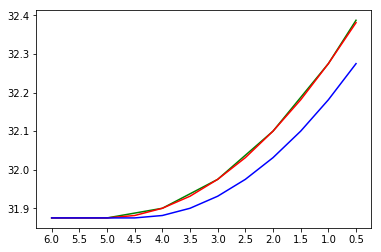

In [8]:
print(var_dual)
obj_dual = np.zeros(nb_point)
for i in range(len(var_dual)):
    obj_dual[0] = obj_sol[0]
    if i != 0:
        obj_dual[i] = obj_sol[i-1] + var_dual[i]
# print(obj_dual)
# print(obj_sol)

plt.plot(cap_array[::-1], obj_feas, color='green')
plt.plot(cap_array[::-1], obj_sol, color='red')
plt.plot(cap_array[::-1], obj_dual, color='blue')
plt.xticks(cap_array, cap_array[::-1])
plt.show()

In [9]:
I210 = 'data/I210'
Chic = 'data/Chicago'
Anah = 'data/Anaheim'
Siou = 'data/SiouxFalls'
Siou2 = 'data/SiouxFalls_bis'
Brae = 'data/braess'

network_name = Siou2
eps=1e-8
nb_iter = 1000
graph, demand = Frank_Wolf_solver.load_network(network_name)

u_old = np.ones(int(np.max(graph[:,0])+1))
u_old = u_old * 50000
# u_old[27] = 20000
# u_old[42] = 20000


path_flow_matrix_old, tt_f_old, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, -1)
delta = delta.T
f_old = delta @ path_flow_matrix_old

nb_point = 5
# obj_feas = np.zeros(nb_point)
obj_sol = np.zeros(nb_point)
cap_array = np.zeros(nb_point)
# var_dual = np.zeros(nb_point)

if export:
    file = open("results_2.txt", "w")

for cap_tmp in range(nb_point):
    graph, demand = Frank_Wolf_solver.load_network(network_name)
    cap = (nb_point - (cap_tmp))/nb_point * 20000
    # c = -1
    u = u_old.copy()
    u[27] = cap
    u[42] = cap
    # path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, c)
    # delta = delta.T
    # f = delta @ path_flow_matrix
    od2route = inv_route_to_od(route2od)

    f_feas = find_feasible(f_old, u, delta, od2route)
    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u)
    delta = delta.T
    f_sol = delta @ path_flow_matrix
    
    if export:
        file2 = open("path_flow_" + str(cap) + ".txt", "w") 
        path_flow_matrix.tofile(file2, sep=",")
        file2.close()

        file3 = open("delta_" + str(cap) + ".txt", "w") 
        delta.T.tofile(file3, sep=",")
        file3.close()

        file.write("New run\n")
        file.write("Route2od, " + str(route2od) + "\n")
        file.write("Capacity, " + str(u) + "\n")
        file.write("Travel time, " + str(tt_f) + "\n")
        file.write("Flow sol, " + str(f_sol) + "\n\n")
    if debug:
        print("++++ TEST ++++")
        print(u_old)
        print(u)
        print((f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1))
        u[27] = f_old[27]
        u[42] = f_old[42]
        var_dual[cap_tmp], dual_vars, _ = lower_bound.lower_bound(f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(u_old), np.array(u), 1)
    
    
    obj_feas[cap_tmp] = Frank_Wolf_solver.potential(graph, f_feas)
    obj_sol[cap_tmp] = Frank_Wolf_solver.potential(graph, f_sol)
    cap_array[cap_tmp] = cap
    
    # file.write(str(cap) + ", flow upperbound, " + str(f_feas) + "\n")
    
    #f_old = f_sol
    #path_flow_matrix_old = path_flow_matrix
    #tt_f_old = tt_f
    #u_old = u
    print()
    print(cap)
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    # print("Objective dual: " + str(var_dual[cap_tmp]))
    
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))
    
if debug:
    print()
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))

if export:
    file.close()


20000.0
Comparing the solutions:
Objective solution: 4379411.756604949
Objective estimate: 4186653.402231611
Link flow solution: [ 3843.07730421  8089.51514695  5237.86873377  6149.80951341
  4896.16611084 15486.30216099 11247.80199335 13138.36546117
 18405.03410741  5670.29091274 17478.57690871  8807.97459185
 15531.89915625  6108.85662405  8791.3164641  12911.26810097
 12696.10127757 16512.05318007 12853.65708386 12783.97412265
  7422.3497303   8687.35762739 14702.99817203  7476.36052022
 21349.26436935 20676.61939191 18380.30040434 19999.99999851
 11560.69273282  9790.80497347  4648.58450166 18403.98744254
  7843.9585327  10494.70364555 10502.38965705  7895.85626871
 13188.02619367 12594.51159338 10916.41018061  9844.55962668
  8834.60900282  7508.61945294 19995.74392987  8474.51971261
 20756.50630164 16806.2097352   8663.68264235 11526.94151013
 11557.19155552 18736.93191658  9758.31781296 11567.6370276
 11419.43342473 16424.22657056 18669.10647233 22687.57914121
 20778.0233105  1


4000.0
Comparing the solutions:
Objective solution: 5325074.008502371
Objective estimate: 4186653.402231611
Link flow solution: [ 4731.76916143  9322.98944509  6599.08068628  6606.10259718
  5258.22290248 17356.31838355 14958.6590432  14130.60522529
 19817.4767249   6053.23011628 17771.91254181  8902.05117511
 14497.79139493  6573.6751752   8879.07078685 15166.59784592
 16227.78588104 15721.78957336 15111.19003566 16294.88992771
  9792.88100678  9784.75566276 12674.71509051  9832.44499064
 19924.5787198  18539.8909593  18514.92990966  3999.99998527
 13718.87551721 12007.17272578  5273.06024648 18575.14727551
  7328.8161107  13845.96224265 14219.60565884  7336.64577056
 17963.97986216 17332.75613766 14195.6824364  13518.1591842
  9314.29049301  7026.86363221  3998.69121046  9267.25731774
 20106.27421098 14203.38392125  9756.9508803  13689.25628682
 10883.9164379  20250.66095979 11990.13946079 10891.9091762
 12850.89665183 15654.72917815 20185.32888905 28928.99163912
 20102.74859165 128

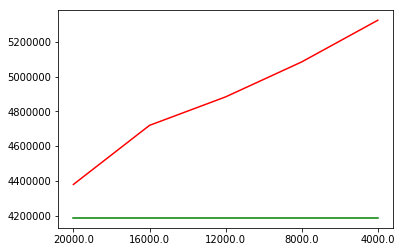

In [14]:
plt.plot(cap_array[::-1], obj_feas[:5], color='green')
plt.plot(cap_array[::-1], obj_sol, color='red')
# plt.plot(cap_array[::-1], obj_dual, color='blue')
plt.xticks(cap_array, cap_array[::-1])
plt.show()

In [ ]:
file = open("delta.txt", "w") 
print(delta.T.tofile(file, sep=","))
file.close()

In [12]:
print(obj_feas)


[4.18665340e+06 4.18665340e+06 4.18665340e+06 4.18665340e+06
 4.18665340e+06 3.19374999e+01 3.19750000e+01 3.20374999e+01
 3.21000000e+01 3.21874999e+01 3.22750000e+01 3.23874999e+01]
